# isaac
wget https://install.launcher.omniverse.nvidia.com/installers/omniverse-launcher-linux.AppImage
refer to: https://docs.omniverse.nvidia.com/isaacsim/latest/installation/install_workstation.html#workstation-setup

In [ ]:
conda create -n isaac python=3.10
conda activate isaac
pip install omni

conda install ipykernel -c conda-forge
!python -m ipykernel install --user --name isaac --display-name "isaac"

In [ ]:
conda install -c conda-forge usd

In [ ]:
from pxr import Usd
print(Usd.__version__)

In [ ]:
import omni
print(dir(omni))

In [ ]:
import omni

omni.kit.start()


In [ ]:
import omni
import numpy as np
from pxr import Usd, UsdGeom, Gf
import math

# 初始化 Isaac Sim
omni.kit.start()

# 加载机械臂模型（例如, UR5）
stage = omni.usd.get_context().get_stage()
arm_path = "/World/UR5"
Usd.Stage.Open("path/to/your/ur5_model.usda")  # 使用你的 URDF/USDA 文件路径

# 设置关节角度
joint_angles = [0, math.pi / 4, math.pi / 4, 0, 0, 0]

# 设置关节角度
for i, angle in enumerate(joint_angles):
    joint_name = f"{arm_path}/joint_{i + 1}"  # 假设关节名称为 joint_1, joint_2, ...
    joint = stage.GetPrimAtPath(joint_name)
    joint.GetAttribute("xformOp:rotateXYZ").Set(value=(0, 0, angle * (180 / np.pi)))  # 转换为度

# 计算末端执行器位置
end_effector_path = f"{arm_path}/end_effector"  # 假设末端执行器路径
end_effector = stage.GetPrimAtPath(end_effector_path)
end_effector_transform = end_effector.GetAttribute("xformOp:transform").Get()

# 输出末端执行器的变换矩阵
print("末端执行器的变换矩阵：")
print(end_effector_transform)

# 停止 Isaac Sim
omni.kit.stop()

# pytransform3d
- [github](https://github.com/dfki-ric/pytransform3d)
- [official website](https://dfki-ric.github.io/pytransform3d/)

In [ ]:
!conda install pytransform3d -c conda-forge

## SO(3): 3D Rotations
refer to: https://dfki-ric.github.io/pytransform3d/user_guide/rotations.html
### Rotation Matrix
<!-- The group of all rotations in the 3D Cartesian space is called SO(3) (SO: special orthogonal group). It is typically represented by 3D rotation matrices [7]. The minimum number of components that are required to describe any rotation from SO(3) is 3. However, there is no representation that is non-redundant, continuous, and free of singularities. -->
三维笛卡尔空间中所有旋转的群称为 SO(3) (SO: 特殊正交群）。它通常用三维旋转矩阵表示。描述 SO(3) 中的任意旋转所需的最小分量数为 3。然而, 没有一种表示是非冗余、连续且没有奇点的。

$SO(3) = \{\boldsymbol{R} \in \mathbb{R}^{3 \times 3} |
\boldsymbol{R}\boldsymbol{R}^T = \boldsymbol{I},
\det(\boldsymbol{R}) = 1\}$
<!-- In addition, $\det(\boldsymbol R) = 1$ because we use right-handed coordinate system ($\det(\boldsymbol R) = -1$ for left-handed coordinate systems). -->
此外, 因为我们使用右手坐标系, 所以 $\det(\boldsymbol R) = 1$ (对于左手坐标系, $\det(\boldsymbol R) = -1$）。

优点:
- 通过矩阵向量乘法, 可以很容易地对点向量应用旋转。
- 通过矩阵乘法, 旋转的连接很简单。
- 您可以直接从列中读取基向量。
- 没有奇点。

缺点:
- 我们使用 9 个值来表示 3 个自由度。
- 并非每个 3x3 矩阵都是有效的旋转矩阵, 这意味着例如我们不能简单地将优化算法应用于旋转矩阵或在旋转矩阵之间进行插值。与四元数相比, 重正规化的计算成本很高。

### Axis-Angle

<!-- Each rotation can be represented by a single rotation about one axis. The axis can be represented as a three-dimensional unit vector and the angle by a scalar: -->
每次旋转都可以表示为绕一个轴的单次旋转。轴可以表示为三维单位向量, 角度可以用标量表示:
$$\begin{split}\left( \hat{\boldsymbol{\omega}}, \theta \right) = \left( \left( \begin{array}{c}\omega_x\\\omega_y\\\omega_z\end{array} \right), \theta \right)\end{split}$$
<!-- pytransform3d uses a numpy array of shape (4,) for the axis-angle representation of a rotation, where the first 3 entries correspond to the unit axis of rotation and the fourth entry to the rotation angle in radians, and typically we use the variable name a. -->
pytransform3d 使用形状为 (4,) 的 numpy 数组来表示旋转的轴角, 其中前 3 个元素对应于旋转的单位轴, 第四个元素对应于以弧度为单位的旋转角度, 通常我们使用变量名$a$。

<!-- Note that the axis-angle representation has a singularity at $\theta = 0$ as there is an infinite number of rotation axes that represent the identity rotation in this case. However, we can modify the representation to avoid this singularity. -->
请注意, 轴角表示在 $\theta = 0$ 处具有奇异点, 因为在这种情况下有无数个旋转轴代表恒等旋转。但是, 我们可以修改表示以避免这种奇异点。

<!-- It is possible to write this in a more compact way as a rotation vector: -->
可以以更紧凑的方式将其写为旋转向量：
$$\boldsymbol{\omega} = \hat{\boldsymbol{\omega}} \theta \in \mathbb{R}^3$$
<!-- pytransform3d uses a numpy array of shape (3,) for the compact axis-angle representation of a rotation and typically we use the variable name a. -->
pytransform3d 使用形状为 (3,) 的 numpy 数组来表示旋转的紧凑轴角, 通常我们使用变量名$a$。

<!-- We can also refer to this representation as **exponential coordinates of rotation**. We can easily represent angular velocity as $\hat{\boldsymbol{\omega}} \dot{\theta}$ and angular acceleration as $\hat{\boldsymbol{\omega}} \ddot{\theta}$ so that we can easily do component-wise integration and differentiation with this representation. In addition, we can represent $\hat{\boldsymbol{\omega}} \theta$ by the cross-product matrix -->
我们也可以将此表示称为**旋转的指数坐标**。我们可以轻松地将角速度表示为 $\hat{\boldsymbol{\omega}} \dot{\theta}$, 将角加速度表示为 $\hat{\boldsymbol{\omega}} \ddot{\theta}$, 这样我们就可以轻松地使用此表示进行逐分量积分和微分。此外, 我们可以用$\hat{\boldsymbol{\omega}} \theta$表示叉积矩阵
$$\begin{split}\left[\hat{\boldsymbol{\omega}}\right] \theta
= \left(
\begin{matrix}
0 & -\omega_3 & \omega_2\\
\omega_3 & 0 & -\omega_1\\
-\omega_2 & \omega_1 & 0\\
\end{matrix}
\right)
\theta
\in so(3)
\subset \mathbb{R}^{3 \times 3},\end{split}$$
<!-- where $\left[\hat{\boldsymbol{\omega}}\right] \theta$ is the matrix logarithm of a rotation matrix and $so(3)$ is the Lie algebra of the Lie group $SO(3)$. -->
其中 $\left[\hat{\boldsymbol{\omega}}\right] \theta$ 是旋转矩阵的矩阵对数, $so(3)$ 是李群 $SO(3)$ 的李代数。

<!-- Pros
- Minimal representation (as rotation vector, also referred to as compact axis-angle in the code).
- Can also represent angular velocity and acceleration when we replace $\theta$ by $\dot{\theta}$ or $\ddot{\theta}$ respectively, which makes numerical integration and differentiation easy. -->
优点
- 最小表示 (作为旋转向量, 在代码中也称为紧凑轴角）。
- 当我们分别用 $\dot{\theta}$ 或 $\ddot{\theta}$ 替换 $\theta$ 时, 也可以表示角速度和加速度, 这使得数值积分和微分变得容易。

<!-- Cons
- There might be discontinuities during interpolation as an angle of 0 and any multiple of $2\pi$ represent the same orientation. This has to be considered. Normalization is recommended.
- When $\theta = \pi$, the axes $\hat{\boldsymbol{\omega}}$ and $-\hat{\boldsymbol{\omega}}$ represent the same rotation, which is a problem for interpolation.
- Concatenation and transformation of vectors requires conversion to rotation matrix or quaternion. -->
缺点
- 插值过程中可能会出现不连续性, 因为 0 角和 $2\pi$ 的任何倍数都表示相同的方向。这点必须考虑。建议进行规范化。
- 当 $\theta = \pi$ 时, 轴 $\hat{\boldsymbol{\omega}}$ 和 $-\hat{\boldsymbol{\omega}}$ 表示相同的旋转, 这对插值来说是一个问题。
- 向量的拼接和变换需要转换为旋转矩阵或四元数。

### Quaternions
<!-- The unit quaternion space $\mathbb{S}^3$ can be used to represent orientations with an encoding based on the rotation axis and angle. A rotation quaternion is a four-dimensional unit vector (versor) $\boldsymbol{\hat{q}}$. The following equation describes its relation to axis-axis notation. -->
单位四元数空间 $\mathbb{S}^3$ 可用于表示基于旋转轴和角度的编码方向。旋转四元数是一个四维单位向量 (versor) $\boldsymbol{\hat{q}}$。以下等式描述了它与轴-轴符号的关系。
$$\begin{split}\boldsymbol{\hat{q}} =
\left( \begin{array}{c} w\\ x\\ y\\ z\\ \end{array} \right) =
\left( \begin{array}{c}
    \cos \frac{\theta}{2}\\
    \omega_x \sin \frac{\theta}{2}\\
    \omega_y \sin \frac{\theta}{2}\\
    \omega_z \sin \frac{\theta}{2}\\
\end{array} \right) =
\left( \begin{array}{c}
    \cos \frac{\theta}{2}\\
    \hat{\boldsymbol{\omega}} \sin \frac{\theta}{2}\\
\end{array} \right)\end{split}$$
<!-- pytransform3d uses a numpy array of shape (4,) for quaternions and typically we use the variable name q. -->
pytransform3d 使用形状为 (4,) 的 numpy 数组作为四元数, 通常我们使用变量名$q$。

<!-- The scalar component $w$ of a quaternion is sometimes the first element and sometimes the last element of the versor. We will use the first element to store the scalar component. -->
四元数的标量分量 $w$ 有时是四元数的第一个元素, 有时是最后一个元素。我们将使用第一个元素来存储标量分量。

<!-- Pros
- More compact than the matrix representation and less susceptible to round-off errors.
- The quaternion elements vary continuously over the unit sphere in $\mathbb{R}^4$ as the orientation changes, avoiding discontinuous jumps (inherent to three-dimensional parameterizations).
- Expression of the rotation matrix in terms of quaternion parameters involves no trigonometric functions.
- Concatenation is simple and computationally cheaper with the quaternion product than with rotation matrices.
- No singularities.
- Renormalization is cheap in comparison to rotation matrices: we only have to divide by the norm of the quaternion. -->
优点
- 比矩阵表示更紧凑, 不易受舍入误差的影响。
- 随着方向的变化, 四元数元素在 $\mathbb{R}^4$ 中的单位球面上连续变化, 避免不连续的跳跃(三维参数化固有的）。
- 用四元数参数表示旋转矩阵不涉及三角函数。
- 与旋转矩阵相比, 使用四元数乘积的拼接更简单, 计算成本更低。
- 没有奇异点。
- 与旋转矩阵相比, 重正规化成本更低: 我们只需除以四元数的范数。

<!-- Cons
- The representation is not straightforward to interpret.
- There are always two unit quaternions that represent exactly the same rotation. -->
缺点
- 该表示法不易解释。
- 总是有两个单位四元数表示完全相同的旋转。

### Euler Angles
refer to: https://dfki-ric.github.io/pytransform3d/user_guide/euler_angles.html

<!-- A complete rotation can be split into three rotations around basis vectors. pytransform3d uses a numpy array of shape (3,) for Euler angles, where each entry corresponds to a rotation angle in radians around one basis vector. The basis vector that will be used and the order of rotation is defined by the convention that we use. See Euler Angles for more information. -->
完整的旋转可以分解为围绕基向量的三次旋转。pytransform3d 使用形状为 (3,) 的 numpy 数组表示欧拉角, 其中每个元素对应于围绕一个基向量的弧度旋转角。

<!-- Pros
- Minimal representation.
- Euler angles are easy to interpret for users (when the convention is clearly defined) in comparison to axis-angle or quaternions. -->
优点
- 最小表示。
- 与轴角或四元数相比, 欧拉角更容易被用户理解(当约定被明确定义时）。

<!-- Cons
- 24 different conventions.
- Singularities (gimbal lock).
- Concatenation and transformation of vectors requires conversion to rotation matrix or quaternion. -->
缺点
- 24 种不同的约定。
- 奇异点 (万向锁）。
- 向量的拼接和变换需要转换为旋转矩阵或四元数。

<!-- Here we rotate about the extrinsic (fixed) x-axis, y-axis, and z-axis by 90 degrees. -->
绕外部(固定)的 x 轴、y 轴和 z 轴旋转 90 度示例如下:

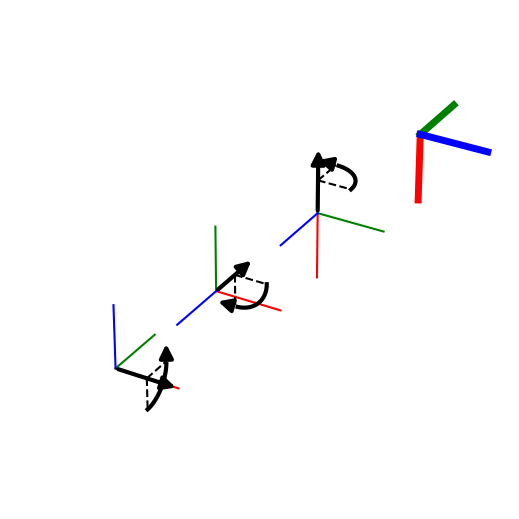

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d.plot_utils import remove_frame


alpha, beta, gamma = 0.5 * np.pi, 0.5 * np.pi, 0.5 * np.pi
p = np.array([1, 1, 1])

plt.figure(figsize=(5, 5))

ax = pr.plot_basis(R=np.eye(3), p=-1.5 * p, ax_s=2)
pr.plot_axis_angle(ax, [1, 0, 0, alpha], -1.5 * p)

pr.plot_basis(
    ax, pr.active_matrix_from_extrinsic_euler_xyz([alpha, 0, 0]), -0.5 * p)
pr.plot_axis_angle(ax, [0, 1, 0, beta], p=-0.5 * p)

pr.plot_basis(
    ax, pr.active_matrix_from_extrinsic_euler_xyz([alpha, beta, 0]), 0.5 * p)
pr.plot_axis_angle(ax, [0, 0, 1, gamma], 0.5 * p)

pr.plot_basis(
    ax,
    pr.active_matrix_from_extrinsic_euler_xyz([alpha, beta, gamma]), 1.5 * p,
    lw=5)

remove_frame(ax)

plt.show()

#### 24 Conventions
<!-- Euler angles generally refer to three consecutive rotations about basis vectors. There are proper Euler angles for which we can distinguish 6 conventions: xzx, xyx, yxy, yzy, zyz, and zxz. As you can see, proper Euler angles rotate about the same basis vector during the first and last rotation and they rotate about another basis vector in the second rotation. In addition, there are Cardan (or Tait-Bryan) angles that rotate about three different basis vectors. There are also 6 conventions: xzy, xyz, yxz, yzx, zyx, and zxy. -->
欧拉角通常指绕基向量的三次连续旋转。有 6 种约定可用于区分 proper Euler angles: xzx、xyx、yxy、yzy、zyz 和 zxz。如您所见, proper Euler angles 在第一次和最后一次旋转期间绕同一基向量旋转, 在第二次旋转期间绕另一个基向量旋转。此外, 还有绕三个不同基向量旋转的 Cardan (or Tait-Bryan) angles。也有 6 种约定: xzy、xyz、yxz、yzx、zyx 和 zxy。

<!-- If you read about [Transformation Ambiguities and Conventions](https://dfki-ric.github.io/pytransform3d/user_guide/transformation_ambiguities.html), you know that the order in which we concatenate rotation matrices matters. We can make extrinsic rotations, in which we rotate about basis vectors of a fixed frame, and we can make intrinsic rotations, in which we rotate about basis vectors of the new, rotated frame. This increases the amount of possible conventions to $2 * (6 + 6) = 24$ (if we only allow active rotation matrices). -->
如果您读过 [Transformation Ambiguities and Conventions](https://dfki-ric.github.io/pytransform3d/user_guide/transformation_ambiguities.html),您就会知道我们拼接旋转矩阵的顺序很重要。我们可以进行外部旋转, 即围绕固定 frame 的基向量旋转, 也可以进行内部旋转, 即围绕新的旋转后 frame 的基向量旋转。这将可能的惯例数量增加到 $2 * (6 + 6) = 24$ (如果我们只允许 active rotation 矩阵）。

> 有多少组欧拉角?  
前面我们也提到欧拉角并没有指定先绕哪一个轴旋转再绕哪一个轴旋转。所以你可以先绕 $x$ 轴转再绕 $y$ 轴转, 你也可以先绕 $y$ 轴转再绕 $x$ 轴转。但是相邻的两次旋转不能是沿着同一个轴(这个很容易理解, 如果两次旋转都是绕着同一个轴, 那么就可以合并为一次旋转, 角度是两次的旋转角相加）。那么这样的刚体系欧拉角有多少组呢? 如果你还记得一点点排列组合的知识, 应该能够写出下面的表达式：
$$n = C_3^1 \cdot C_2^1 \cdot C_2^1$$
同理世界系欧拉角也有12种。因此这样的欧拉角总共有24种
refer to: https://blog.csdn.net/hitgavin/article/details/105210991

#### Range of Angles
<!-- Euler angles rotate about three basis vectors with by the angles $\alpha$, $\beta$, and $\gamma$. If we want to find the Euler angles that correspond to one rotation matrix $R$, there is an infinite number of solutions because we can always add or subtract $2\pi$ to one of the angles and get the same result. In addition, for proper Euler angles -->
欧拉角绕三个基向量旋转的角度分别为 $\alpha$、$\beta$ 和 $\gamma$。如果我们想找到与一个旋转矩阵 $R$ 相对应的欧拉角, 则有无数个解, 因为我们总是可以在其中一个角度上加或减 $2\pi$ 并得到相同的结果。此外, 对于 proper Euler angles
$$R(\alpha, \beta, \gamma) = R(\alpha + \pi, -\beta, \gamma - \pi).$$
<!-- For Cardan angles -->
对于 Cardan angles
$$R(\alpha, \beta, \gamma) = R(\alpha + \pi, \pi - \beta, \gamma - \pi).$$
<!-- For this reason the proper Euler angles are typically restricted to -->
因此, proper Euler angles 通常限制为
$$-\pi \leq \alpha < \pi, \qquad 0 \leq \beta \leq \pi, \qquad -\pi \leq \gamma < \pi$$
<!-- and Cardan angles are usually restricted to -->
Cardan angles 通常限制为
$$-\pi \leq \alpha < \pi, \qquad -\frac{\pi}{2} \leq \beta \leq \frac{\pi}{2}, \qquad -\pi \leq \gamma < \pi$$
<!-- to make these representations unique. -->
使得这些表示独一无二。


#### Gimbal Lock
<!-- The special case of a so-called gimbal lock occurs when the second angle $\beta$ is at one of its limits. In this case the axis of rotation for the first and last rotation are either the same or exactly opposite, that is, an infinite number of angles $\alpha$ and $\gamma$ will represent the same rotation even though we restricted their range to an interval of length $2\pi$: either all pairs of angles that satisfy $\alpha + \gamma = constant$ or all pairs of angles that satisfy $\alpha - \gamma = constant$. When we reconstruct Euler angles from a rotation matrix, we set one of these angles to 0 to determine the other. -->
当第二个角度 $\beta$ 处于其极值之一时, 就会出现所谓的 gimbal lock 的特殊情况。在这种情况下, 第一次和最后一次旋转的旋转轴要么相同, 要么完全相反, 也就是说, 即使我们将它们的范围限制在长度为 $2\pi$ 的区间内, 无数个角度 $\alpha$ 和 $\gamma$ 也将表示相同的旋转: 要么满足 $\alpha + \gamma = 常数 $ 的所有角度对, 要么满足 $\alpha - \gamma = 常数 $ 的所有角度对。当我们从旋转矩阵重建欧拉角时, 我们将其中一个角度设置为 0 以确定另一个角度。

## case

- [Animate Rotation](https://dfki-ric.github.io/pytransform3d/_auto_examples/animations/animate_rotation.html#sphx-glr-auto-examples-animations-animate-rotation-py)<br>使用 Matplotlib 的 FuncAnimation 可以轻松实现 frames 和轨迹的简单动画。以下示例将生成一个绕 x 轴旋转的 frame。
- [Animate Trajectory](https://dfki-ric.github.io/pytransform3d/_auto_examples/animations/animate_trajectory.html#sphx-glr-auto-examples-animations-animate-trajectory-py)
- [Quaternion Integration](https://dfki-ric.github.io/pytransform3d/_auto_examples/animations/animate_quaternion_integration.html#sphx-glr-auto-examples-animations-animate-quaternion-integration-py)<br>将角加速度积分到四元数序列并制作动画。
- [Interpolate Between Axis-Angle Representations](https://dfki-ric.github.io/pytransform3d/_auto_examples/animations/animate_angle_axis_interpolation.html#sphx-glr-auto-examples-animations-animate-angle-axis-interpolation-py)<br>我们可以在由一个轴和一个角度表示的两个 orientations 之间进行线性插值, 或使用球面线性插值 (slerp)。在这里, 我们比较这两种方法, 并测量两个连续步骤之间的角速度。我们可以看到, 线性插值会导致非恒定角速度。通常, 使用 slerp 进行插值是一个更好的注意。
- [Interpolate Between Quaternion Orientations](https://dfki-ric.github.io/pytransform3d/_auto_examples/animations/animate_quaternion_interpolation.html#sphx-glr-auto-examples-animations-animate-quaternion-interpolation-py)<br>我们可以在由四元数表示的两个 orientations 之间进行线性插值, 或使用球面线性插值。在这里, 我们比较了这两种方法, 并测量了两个连续步骤之间的角速度。我们可以看到, 线性插值会导致非恒定角速度。通常, 使用 slerp 进行插值是一个更好的注意。

### [由两个向量构建旋转矩阵](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_matrix_from_two_vectors.html#sphx-glr-auto-examples-plots-plot-matrix-from-two-vectors-py)
根据构成平面的两个向量, 计算旋转矩阵。x 轴将指向与第一个向量相同的方向, y 轴对应于向量 b 在向量 a 上的正交分量, z 轴是其他基向量的叉乘。

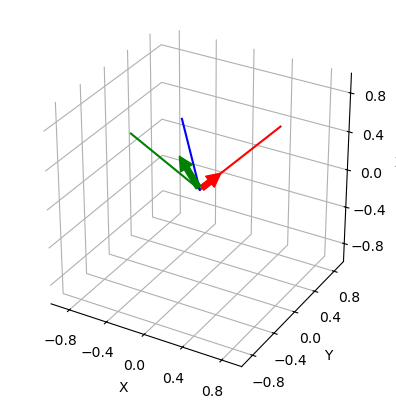

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import (
    matrix_from_two_vectors, plot_basis, random_vector)
from pytransform3d.plot_utils import plot_vector


rng = np.random.default_rng(1)
a = random_vector(rng, 3) * 0.3 # 生成一个三维随机向量，并将其缩放到 0.3 的长度
b = random_vector(rng, 3) * 0.3
R = matrix_from_two_vectors(a, b)

ax = plot_vector(direction=a, color="r")   # 使用红色绘制向量 a
plot_vector(ax=ax, direction=b, color="g") # 使用绿色绘制向量 b
plot_basis(ax=ax, R=R)
plt.show()

### [两个方向向量的轴角表示](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_axis_angle_from_two_vectors.html#sphx-glr-auto-examples-plots-plot-axis-angle-from-two-vectors-py)
此示例展示了如何计算旋转的轴角表示，该旋转将向量 a 指定的方向转换为向量 b 指定的方向。我们展示了两个向量, 绕旋转轴的旋转, 以及初始和结束坐标系, 其中向量 b 及其旋转后的对应坐标系用短线表示。


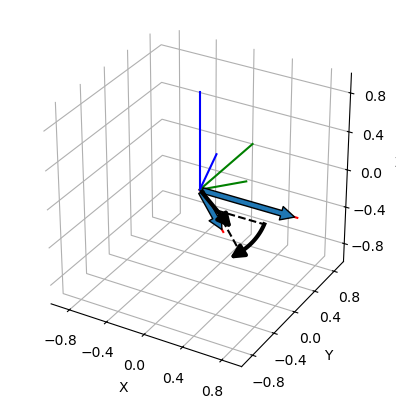

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import (
    axis_angle_from_two_directions, matrix_from_axis_angle, plot_axis_angle,
    plot_basis)
from pytransform3d.plot_utils import make_3d_axis, plot_vector


a = np.array([1.0, 0.0, 0.0])
b = np.array([0.76958075, -0.49039301, -0.40897453])
aa = axis_angle_from_two_directions(a, b)

ax = make_3d_axis(ax_s=1)
plot_vector(ax, start=np.zeros(3), direction=a, s=1.0)
plot_vector(ax, start=np.zeros(3), direction=b, s=0.5)
plot_axis_angle(ax, aa)
plot_basis(ax)
plot_basis(ax, R=matrix_from_axis_angle(aa), s=0.5)
plt.show()

### [旋转的轴角表示](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_axis_angle.html#sphx-glr-auto-examples-plots-plot-axis-angle-py)

任何旋转都可以用绕某个轴一个次旋转来表示。这里我们看到一 frame, 它架绕旋转分多步旋转。

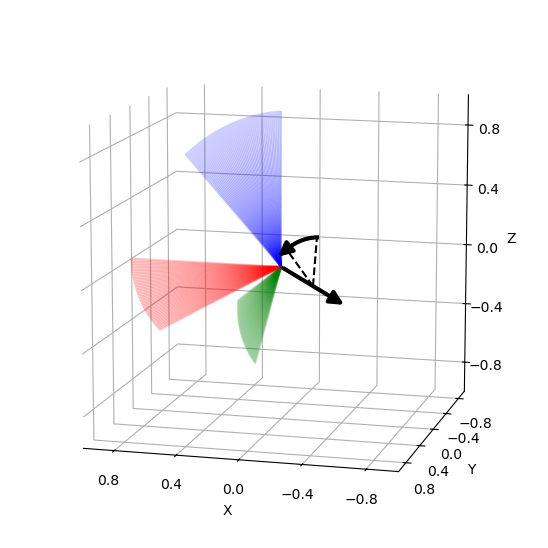

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import (random_axis_angle, matrix_from_axis_angle,
                                     plot_basis, plot_axis_angle)

original = random_axis_angle(np.random.RandomState(5))
ax = plot_axis_angle(a=original)
for fraction in np.linspace(0, 1, 50):
    a = original.copy()
    a[-1] = fraction * original[-1]
    R = matrix_from_axis_angle(a)
    plot_basis(ax, R, alpha=0.2)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1.1)
ax.view_init(azim=105, elev=12)
plt.show()

### [比较旋转的不同定义](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_compare_rotations.html#sphx-glr-auto-examples-plots-plot-compare-rotations-py)

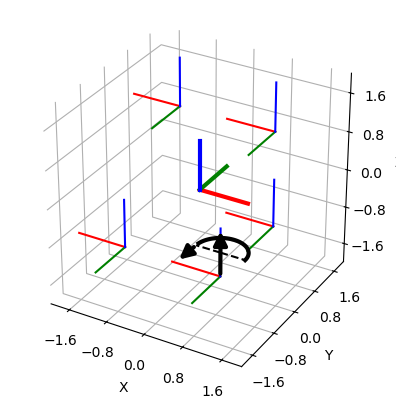

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr


ax = pr.plot_basis(R=np.eye(3), ax_s=2, lw=3)
axis = 2
angle = np.pi

p = np.array([1.0, 1.0, 1.0])
euler = [0, 0, 0]
euler[axis] = angle
R = pr.active_matrix_from_intrinsic_euler_xyz(euler)
pr.plot_basis(ax, R, p)

p = np.array([-1.0, 1.0, 1.0])
euler = [0, 0, 0]
euler[2 - axis] = angle
R = pr.active_matrix_from_intrinsic_euler_zyx(euler)
pr.plot_basis(ax, R, p)

p = np.array([1.0, 1.0, -1.0])
R = pr.active_matrix_from_angle(axis, angle)
pr.plot_basis(ax, R, p)

p = np.array([1.0, -1.0, -1.0])
e = [pr.unitx, pr.unity, pr.unitz][axis]
a = np.hstack((e, (angle,)))
R = pr.matrix_from_axis_angle(a)
pr.plot_basis(ax, R, p)
pr.plot_axis_angle(ax, a, p)

p = np.array([-1.0, -1.0, -1.0])
q = pr.quaternion_from_axis_angle(a)
R = pr.matrix_from_quaternion(q)
pr.plot_basis(ax, R, p)

plt.show()

### [Transform Concatenation](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_transform_concatenation.html#sphx-glr-auto-examples-plots-plot-transform-concatenation-py)
在这个例子中, 我们有一个点 p, 它定义在frame C 中, 我们已知transform C2B 和 B2A。我们可以构造一个transform C2A, 以提取 p 在frame A 中的位置。

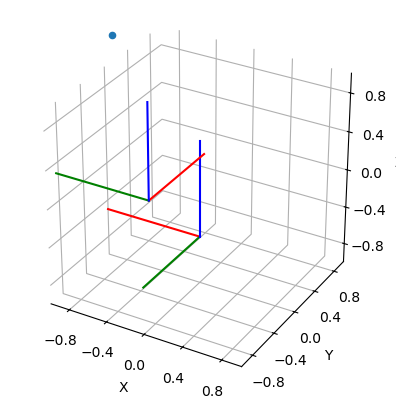

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.rotations as pyrot
import pytransform3d.transformations as pytr


p = np.array([0.0, 0.0, -0.5])
a = np.array([0.0, 0.0, 1.0, np.pi])
B2A = pytr.transform_from(pyrot.matrix_from_axis_angle(a), p)

p = np.array([0.3, 0.4, 0.5])
a = np.array([0.0, 0.0, 1.0, -np.pi / 2.0])
C2B = pytr.transform_from(pyrot.matrix_from_axis_angle(a), p)

C2A = pytr.concat(C2B, B2A)
p = pytr.transform(C2A, np.ones(4))

ax = pytr.plot_transform(A2B=B2A)
pytr.plot_transform(ax, A2B=C2A)
ax.scatter(p[0], p[1], p[2])
plt.show()

### [Plot with Respect to Different Reference Frames](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_frames.html#sphx-glr-auto-examples-plots-plot-frames-py)
我们将演示如何使用`TransformManager`。我们将向管理器添加几个 transforms, 并在两个参考系('world' 和 'A')中绘制所有 frames。

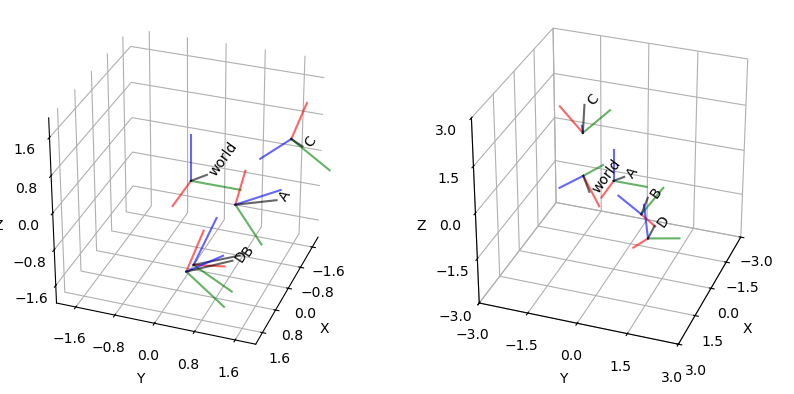

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.transformations import random_transform
from pytransform3d.transform_manager import TransformManager


rng = np.random.default_rng(5)
A2world = random_transform(rng)
B2world = random_transform(rng)
A2C = random_transform(rng)
D2B = random_transform(rng)

tm = TransformManager()
tm.add_transform("A", "world", A2world)
tm.add_transform("B", "world", B2world)
tm.add_transform("A", "C", A2C)
tm.add_transform("D", "B", D2B)

plt.figure(figsize=(10, 5))

ax = make_3d_axis(2, 121)
ax = tm.plot_frames_in("world", ax=ax, alpha=0.6)
ax.view_init(30, 20)

ax = make_3d_axis(3, 122)
ax = tm.plot_frames_in("A", ax=ax, alpha=0.6)
ax.view_init(30, 20)

plt.show()

### [Transformation Manager](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_transform_manager.html#sphx-glr-auto-examples-plots-plot-transform-manager-py)
我们将使用`TransformManager`自动推理transformation。

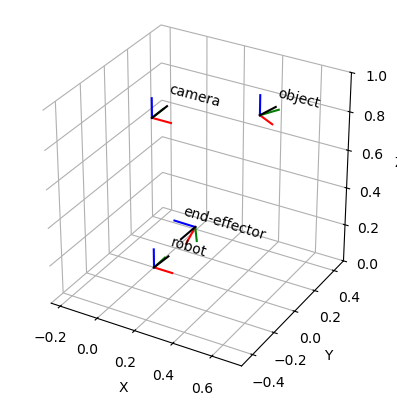

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager


rng = np.random.default_rng(1)

ee2robot = pt.transform_from_pq(
    np.hstack((np.array([0.4, -0.3, 0.5]),
               pr.random_quaternion(rng))))
cam2robot = pt.transform_from_pq(
    np.hstack((np.array([0.0, 0.0, 0.8]), pr.q_id)))
object2cam = pt.transform_from(
    pr.active_matrix_from_intrinsic_euler_xyz(np.array([0.0, 0.0, -0.5])),
    np.array([0.5, 0.1, 0.1]))

tm = TransformManager()
tm.add_transform("end-effector", "robot", ee2robot)
tm.add_transform("camera", "robot", cam2robot)
tm.add_transform("object", "camera", object2cam)

ee2object = tm.get_transform("end-effector", "object")

ax = tm.plot_frames_in("robot", s=0.1)
ax.set_xlim((-0.25, 0.75))
ax.set_ylim((-0.5, 0.5))
ax.set_zlim((0.0, 1.0))
plt.show()

### [旋转约定: Passive / Active, Extrinsic / Intrinsic](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_convention_rotation_global_local.html#sphx-glr-auto-examples-plots-plot-convention-rotation-global-local-py)
我们将比较 passive 和 active 旋转, 以及 extrinsic 和 intrinsic 旋转拼接的所有可能组合。

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from pytransform3d.rotations import (
    passive_matrix_from_angle, active_matrix_from_angle, plot_basis)

#### Passive Extrinsic Rotations

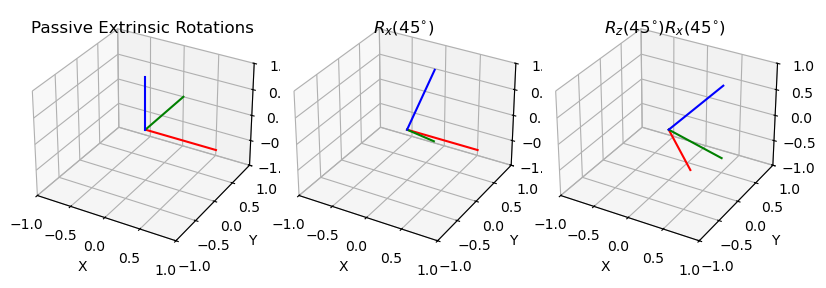

In [33]:
plt.figure(figsize=(8, 3))
axes = [plt.subplot(1, 3, 1 + i, projection="3d") for i in range(3)]
for ax in axes:
    plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1),
             xlabel="X", ylabel="Y", zlabel="Z")

Rx45 = passive_matrix_from_angle(0, np.deg2rad(45))
Rz45 = passive_matrix_from_angle(2, np.deg2rad(45))

axes[0].set_title("Passive Extrinsic Rotations", y=0.95)
plot_basis(ax=axes[0], R=np.eye(3))
axes[1].set_title("$R_x(45^{\circ})$", y=0.95)
plot_basis(ax=axes[1], R=Rx45)
axes[2].set_title("$R_z(45^{\circ}) R_x(45^{\circ})$", y=0.95)
plot_basis(ax=axes[2], R=Rz45.dot(Rx45))

plt.tight_layout()

#### Passive Intrinsic Rotations

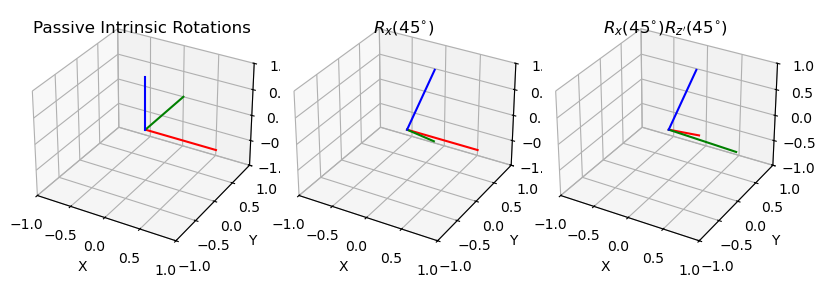

In [34]:
plt.figure(figsize=(8, 3))
axes = [plt.subplot(1, 3, 1 + i, projection="3d") for i in range(3)]
for ax in axes:
    plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1),
             xlabel="X", ylabel="Y", zlabel="Z")

axes[0].set_title("Passive Intrinsic Rotations", y=0.95)
plot_basis(ax=axes[0], R=np.eye(3))
axes[1].set_title("$R_x(45^{\circ})$", y=0.95)
plot_basis(ax=axes[1], R=Rx45)
axes[2].set_title("$R_x(45^{\circ}) R_{z'}(45^{\circ})$", y=0.95)
plot_basis(ax=axes[2], R=Rx45.dot(Rz45))

plt.tight_layout()

#### Active Extrinsic Rotations

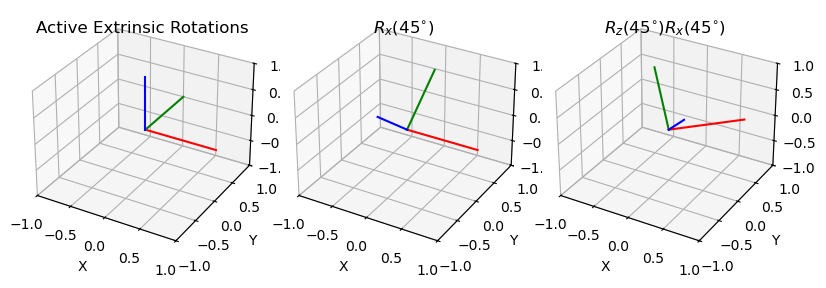

In [35]:
plt.figure(figsize=(8, 3))
axes = [plt.subplot(1, 3, 1 + i, projection="3d") for i in range(3)]
for ax in axes:
    plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1),
             xlabel="X", ylabel="Y", zlabel="Z")

Rx45 = active_matrix_from_angle(0, np.deg2rad(45))
Rz45 = active_matrix_from_angle(2, np.deg2rad(45))

axes[0].set_title("Active Extrinsic Rotations", y=0.95)
plot_basis(ax=axes[0], R=np.eye(3))
axes[1].set_title("$R_x(45^{\circ})$", y=0.95)
plot_basis(ax=axes[1], R=Rx45)
axes[2].set_title("$R_z(45^{\circ}) R_x(45^{\circ})$", y=0.95)
plot_basis(ax=axes[2], R=Rz45.dot(Rx45))

plt.tight_layout()

#### Active Intrinsic Rotations

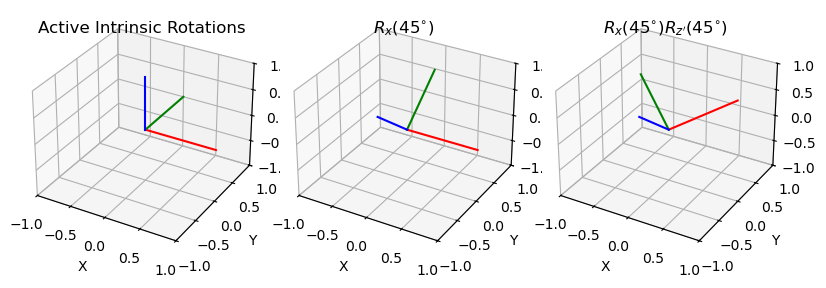

In [36]:
plt.figure(figsize=(8, 3))
axes = [plt.subplot(1, 3, 1 + i, projection="3d") for i in range(3)]
for ax in axes:
    plt.setp(ax, xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1),
             xlabel="X", ylabel="Y", zlabel="Z")

axes[0].set_title("Active Intrinsic Rotations", y=0.95)
plot_basis(ax=axes[0], R=np.eye(3))
axes[1].set_title("$R_x(45^{\circ})$", y=0.95)
plot_basis(ax=axes[1], R=Rx45)
axes[2].set_title("$R_x(45^{\circ}) R_{z'}(45^{\circ})$", y=0.95)
plot_basis(ax=axes[2], R=Rx45.dot(Rz45))

plt.tight_layout()

plt.show()

### [Pose Trajectory](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_pose_trajectory.html#sphx-glr-auto-examples-plots-plot-pose-trajectory-py)

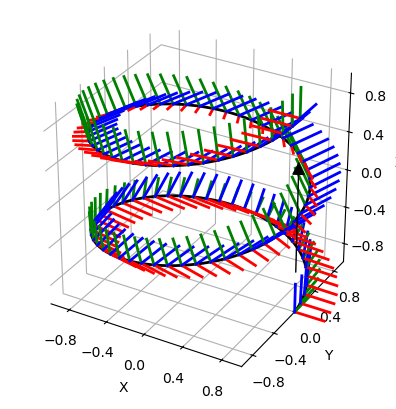

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.batch_rotations import quaternion_slerp_batch
from pytransform3d.rotations import q_id
from pytransform3d.trajectories import plot_trajectory


n_steps = 100000
P = np.empty((n_steps, 7))
P[:, 0] = np.cos(np.linspace(-2 * np.pi, 2 * np.pi, n_steps))
P[:, 1] = np.sin(np.linspace(-2 * np.pi, 2 * np.pi, n_steps))
P[:, 2] = np.linspace(-1, 1, n_steps)
q_end = np.array([0.0, 0.0, np.sqrt(0.5), np.sqrt(0.5)])
P[:, 3:] = quaternion_slerp_batch(q_id, q_end, np.linspace(0, 1, n_steps))

ax = plot_trajectory(
    P=P, s=0.3, n_frames=100, normalize_quaternions=False, lw=2, c="k")
plt.show()

### [旋转圆柱体](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_rotate_cylinder.html#sphx-glr-auto-examples-plots-plot-rotate-cylinder-py)
我们在圆柱体的重心处施加一个恒定的扭矩(tau), 并逐步绘制它的加速过程。

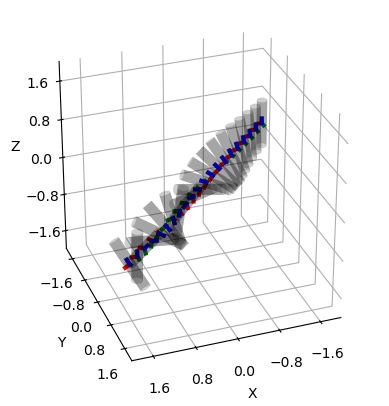

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import matrix_from_compact_axis_angle
from pytransform3d.transformations import transform_from, plot_transform
from pytransform3d.plot_utils import plot_cylinder


def inertia_of_cylinder(mass, length, radius):
    I_xx = I_yy = 0.25 * mass * radius ** 2 + 1.0 / 12.0 * mass * length ** 2
    I_zz = 0.5 * mass * radius ** 2
    return np.eye(3) * np.array([I_xx, I_yy, I_zz])


A2B = np.eye(4)

length = 1.0
radius = 0.1
mass = 1.0
dt = 0.2
inertia = inertia_of_cylinder(mass, length, radius)
tau = np.array([0.05, 0.05, 0.0])
angular_velocity = np.zeros(3)
orientation = np.zeros(3)

ax = None
for p_xy in np.linspace(-2, 2, 21):
    A2B = transform_from(R=matrix_from_compact_axis_angle(orientation),
                         p=np.array([p_xy, p_xy, 0.0]))
    ax = plot_cylinder(length=length, radius=radius, A2B=A2B, wireframe=False,
                       alpha=0.2, ax_s=2.0, ax=ax)
    plot_transform(ax=ax, A2B=A2B, s=radius, lw=3)

    angular_acceleration = np.linalg.inv(inertia).dot(tau)
    angular_velocity += dt * angular_acceleration
    orientation += dt * angular_velocity
ax.view_init(elev=30, azim=70)
plt.show()

#### [Plot Random Geometries](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_random_geometries.html#sphx-glr-auto-examples-plots-plot-random-geometries-py)

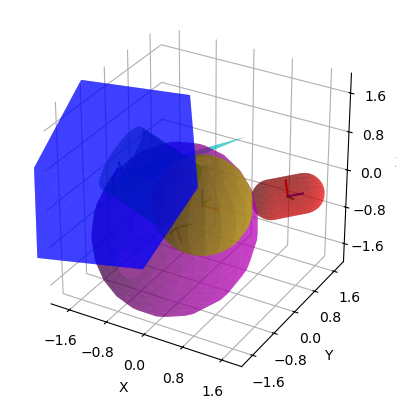

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import (
    make_3d_axis, plot_box, plot_sphere, plot_cylinder, plot_ellipsoid,
    plot_capsule, plot_cone)
from pytransform3d.transformations import (
    random_transform, plot_transform, translate_transform)


rng = np.random.default_rng(2834)
ax = make_3d_axis(2)

box2origin = random_transform(rng)
size = rng.random(size=3) * 3
plot_transform(ax=ax, A2B=box2origin, s=0.3)
plot_box(ax=ax, A2B=box2origin, size=size, color="b", alpha=0.5,
         wireframe=False)

p = rng.standard_normal(size=3)
radius = float(rng.random())
plot_transform(ax=ax, A2B=translate_transform(np.eye(4), p), s=0.3)
plot_sphere(ax=ax, p=p, radius=radius, color="y", alpha=0.5, wireframe=False)

cylinder2origin = random_transform(rng)
length = float(rng.random()) * 5
radius = float(rng.random())
plot_transform(ax=ax, A2B=cylinder2origin, s=0.3)
plot_cylinder(ax=ax, A2B=cylinder2origin, length=length, radius=radius,
              color="g", alpha=0.5, wireframe=False)

ellipsoid2origin = random_transform(rng)
radii = rng.random(size=3) * 3
plot_transform(ax=ax, A2B=ellipsoid2origin, s=0.3)
plot_ellipsoid(ax=ax, A2B=ellipsoid2origin, radii=radii, color="m", alpha=0.5,
               wireframe=False)

capsule2origin = random_transform(rng)
height = float(rng.random()) * 2
radius = float(rng.random())
plot_transform(ax=ax, A2B=capsule2origin, s=0.3)
plot_capsule(ax=ax, A2B=capsule2origin, height=height, radius=radius,
             color="r", alpha=0.5, wireframe=False)

cone2origin = random_transform(rng)
height = float(rng.random()) * 5
radius = float(rng.random())
plot_transform(ax=ax, A2B=cone2origin, s=0.3)
plot_cone(ax=ax, A2B=cone2origin, height=height, radius=radius, color="c",
          alpha=0.5, wireframe=False)

plt.show()

#### [Plot Transformed Cylinders](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_cylinder.html#sphx-glr-auto-examples-plots-plot-cylinder-py)

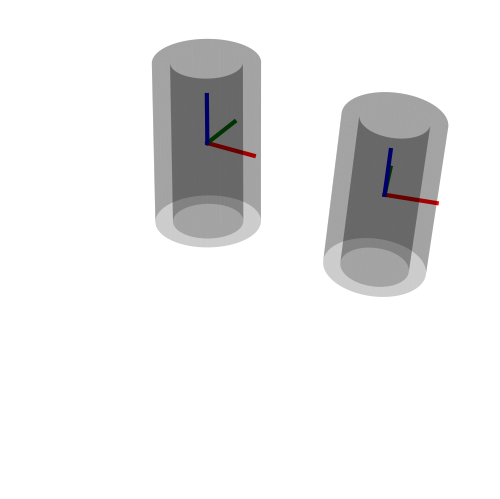

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.transformations import transform_from, plot_transform
from pytransform3d.rotations import random_axis_angle, matrix_from_axis_angle
from pytransform3d.plot_utils import plot_cylinder, remove_frame


rng = np.random.default_rng(44)
A2B = transform_from(
    R=matrix_from_axis_angle(random_axis_angle(rng)),
    p=rng.standard_normal(size=3))
ax = plot_cylinder(length=1.0, radius=0.3, thickness=0.1,
                   wireframe=False, alpha=0.2)
plot_transform(ax=ax, A2B=np.eye(4), s=0.3, lw=3)
plot_cylinder(ax=ax, length=1.0, radius=0.3, thickness=0.1, A2B=A2B,
              wireframe=False, alpha=0.2)
plot_transform(ax=ax, A2B=A2B, s=0.3, lw=3)
remove_frame(ax)
ax.set_xlim((0, 1.5))
ax.set_ylim((-1.5, 0))
ax.set_zlim((-0.8, 0.7))
plt.show()

#### [Plot Box](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_box.html#sphx-glr-auto-examples-plots-plot-box-py)

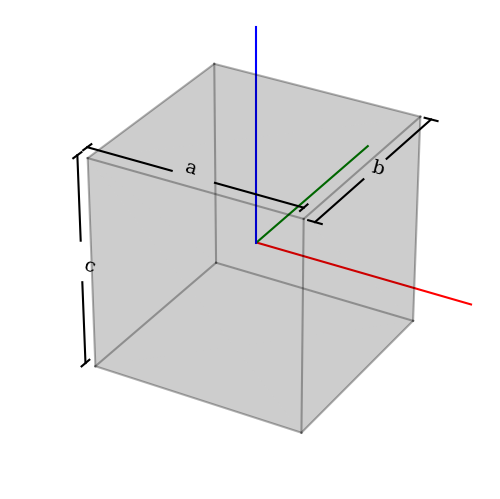

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import (plot_box, plot_length_variable,
                                      remove_frame)
from pytransform3d.transformations import plot_transform


plt.figure()
ax = plot_box(size=[1, 1, 1], wireframe=False, alpha=0.1, color="k", ax_s=0.6)
plot_transform(ax=ax)
plot_box(ax=ax, size=[1, 1, 1], wireframe=True, alpha=0.3)
plot_length_variable(
    ax=ax,
    start=np.array([-0.5, -0.5, 0.55]), end=np.array([0.5, -0.5, 0.55]),
    name="a",
    fontsize=14, fontfamily="serif")
plot_length_variable(
    ax=ax,
    start=np.array([0.55, -0.5, 0.5]), end=np.array([0.55, 0.5, 0.5]),
    name="b",
    fontsize=14, fontfamily="serif")
plot_length_variable(
    ax=ax,
    start=np.array([-0.55, -0.5, -0.5]), end=np.array([-0.55, -0.5, 0.5]),
    name="c",
    fontsize=14, fontfamily="serif")
remove_frame(ax)
plt.show()

### [Camera Trajectory](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_camera_trajectory.html#sphx-glr-auto-examples-plots-plot-camera-trajectory-py)
下图显示了根据里程计估算出的相机轨迹。该特定轨迹已用于从深度相机和 RGB 相机重建彩色网格。

In [ ]:
%cd /mnt/d/github
!git clone https://github.com/dfki-ric/pytransform3d.git

In [20]:
%cd /mnt/d/github/pytransform3d

/mnt/d/github/pytransform3d


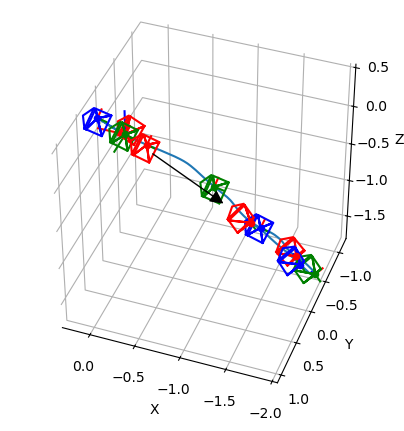

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.rotations as pr
import pytransform3d.camera as pc
from cycler import cycle


BASE_DIR = "test/test_data/"
data_dir = BASE_DIR
search_path = "."
while (not os.path.exists(data_dir) and
       os.path.dirname(search_path) != "pytransform3d"):
    search_path = os.path.join(search_path, "..")
    data_dir = os.path.join(search_path, BASE_DIR)

intrinsic_matrix = np.loadtxt(os.path.join(
    data_dir, "reconstruction_camera_matrix.csv"), delimiter=",")

P = np.loadtxt(os.path.join(data_dir, "reconstruction_odometry.csv"),
               delimiter=",", skiprows=1)
for t in range(len(P)):
    P[t, 3:] = pr.quaternion_wxyz_from_xyzw(P[t, 3:])
cam2world_trajectory = ptr.transforms_from_pqs(P)

plt.figure(figsize=(5, 5))
ax = pt.plot_transform(s=0.3)
ax = ptr.plot_trajectory(ax, P=P, s=0.1, n_frames=10)

image_size = np.array([1920, 1440])

key_frames_indices = np.linspace(0, len(P) - 1, 10, dtype=int)
colors = cycle("rgb")
for i, c in zip(key_frames_indices, colors):
    pc.plot_camera(ax, intrinsic_matrix, cam2world_trajectory[i],
                   sensor_size=image_size, virtual_image_distance=0.2, c=c)

pos_min = np.min(P[:, :3], axis=0)
pos_max = np.max(P[:, :3], axis=0)
center = (pos_max + pos_min) / 2.0
max_half_extent = max(pos_max - pos_min) / 2.0
ax.set_xlim((center[0] - max_half_extent, center[0] + max_half_extent))
ax.set_ylim((center[1] - max_half_extent, center[1] + max_half_extent))
ax.set_zlim((center[2] - max_half_extent, center[2] + max_half_extent))

ax.view_init(azim=110, elev=40)

plt.show()

#### [3D 相机表示](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_camera_3d.html#sphx-glr-auto-examples-plots-plot-camera-3d-py)
该可视化化受 Blender 相机可视化的启发。它将显示相机中心距相机中心一定距离的虚拟图像平面, 面以及虚拟图像平面的顶部方向。

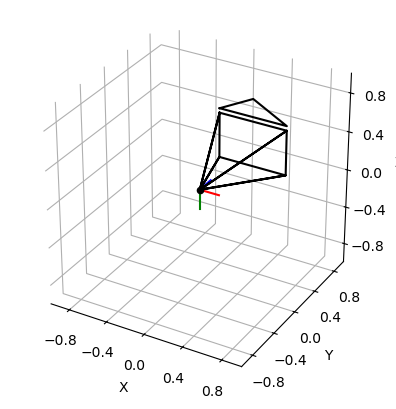

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt


cam2world = pt.transform_from_pq([0, 0, 0, np.sqrt(0.5), -np.sqrt(0.5), 0, 0])
# default parameters of a camera in Blender
sensor_size = np.array([0.036, 0.024])
intrinsic_matrix = np.array([
    [0.05, 0, sensor_size[0] / 2.0],
    [0, 0.05, sensor_size[1] / 2.0],
    [0, 0, 1]
])
virtual_image_distance = 1

ax = pt.plot_transform(A2B=cam2world, s=0.2)
pc.plot_camera(
    ax, cam2world=cam2world, M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)
plt.show()

### [四元数积分](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_quaternion_integrate.html#sphx-glr-auto-examples-plots-plot-quaternion-integrate-py)
积分角速度, 得到四元数序列。

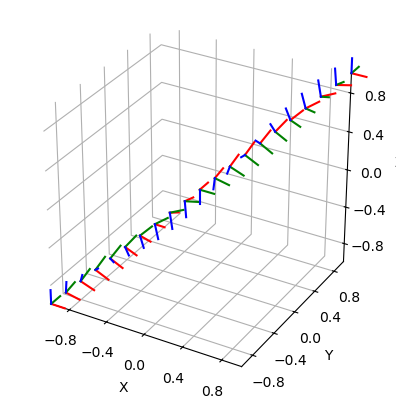

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import (
    quaternion_integrate, matrix_from_quaternion, plot_basis)


angular_velocities = np.empty((21, 3))
angular_velocities[:, :] = np.array([np.sqrt(0.5), np.sqrt(0.5), 0.0])
angular_velocities *= np.pi

Q = quaternion_integrate(angular_velocities, dt=0.1)
ax = None
for t in range(len(Q)):
    R = matrix_from_quaternion(Q[t])
    p = 2 * (t / (len(Q) - 1) - 0.5) * np.ones(3)
    ax = plot_basis(ax=ax, s=0.15, R=R, p=p)
plt.show()

### [四元数的球面线性插值](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_quaternion_slerp.html#sphx-glr-auto-examples-plots-plot-quaternion-slerp-py)
对于小角度旋转, 四元数的线性插值几乎与球面线性插值 (SLERP) 产生相同的结果。对于较大的角度, 如本例所示, 存在显著差异。外圆使用线性插值, 内圆使用 SLERP。您可以在本例中尝试使用`end_angle`的值。

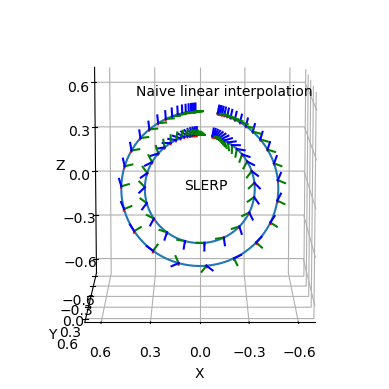

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import (
    matrix_from_axis_angle, quaternion_from_matrix, quaternion_slerp)
from pytransform3d.trajectories import plot_trajectory


T = np.linspace(0, 1, 1001)
sigmoid = 0.5 * (np.tanh(1.5 * np.pi * (T - 0.5)) + 1.0)
radius = 0.5
start_angle = np.deg2rad(0.0)
end_angle = np.deg2rad(350.0)

R1 = matrix_from_axis_angle([0, 0, 1, 0.5 * np.pi])
R2_start = matrix_from_axis_angle([1, 0, 0, start_angle])
R2_end = matrix_from_axis_angle([1, 0, 0, end_angle])
q_start = quaternion_from_matrix(R1.dot(R2_start))
q_end = quaternion_from_matrix(R1.dot(R2_end))

Y = np.zeros((len(T), 7))
Y[:, 0] = radius * np.cos(np.deg2rad(90) - end_angle * sigmoid)
Y[:, 2] = radius * np.sin(np.deg2rad(90) - end_angle * sigmoid)
if end_angle > np.pi:
    q_end *= -1.0
Y[:, 3:] = (1.0 - T)[:, np.newaxis] * q_start + T[:, np.newaxis] * q_end

Y_slerp = np.zeros((len(T), 7))
Y_slerp[:, 0] = 0.7 * radius * np.cos(np.deg2rad(90) - end_angle * sigmoid)
Y_slerp[:, 2] = 0.7 * radius * np.sin(np.deg2rad(90) - end_angle * sigmoid)
for i, t in enumerate(T):
    Y_slerp[i, 3:] = quaternion_slerp(q_start, q_end, t)

ax = plot_trajectory(
    P=Y[:, :7], show_direction=False, n_frames=40, s=0.05, ax_s=0.7)
ax = plot_trajectory(
    P=Y_slerp[:, :7], show_direction=False, n_frames=40, s=0.05, ax=ax)
ax.text(0.1, 0, 0, "SLERP")
ax.text(0.4, 0, 0.6, "Naive linear interpolation")
ax.view_init(elev=10, azim=90)
plt.show()

### [管理随时间变化的 Transformations](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_interpolation_for_transform_manager.html#sphx-glr-auto-examples-plots-plot-interpolation-for-transform-manager-py)
给定两条 3D 刚性变换轨迹, 我们将对两条轨迹进行插值，并使用 transform 管理器进行目标时间步的操作。

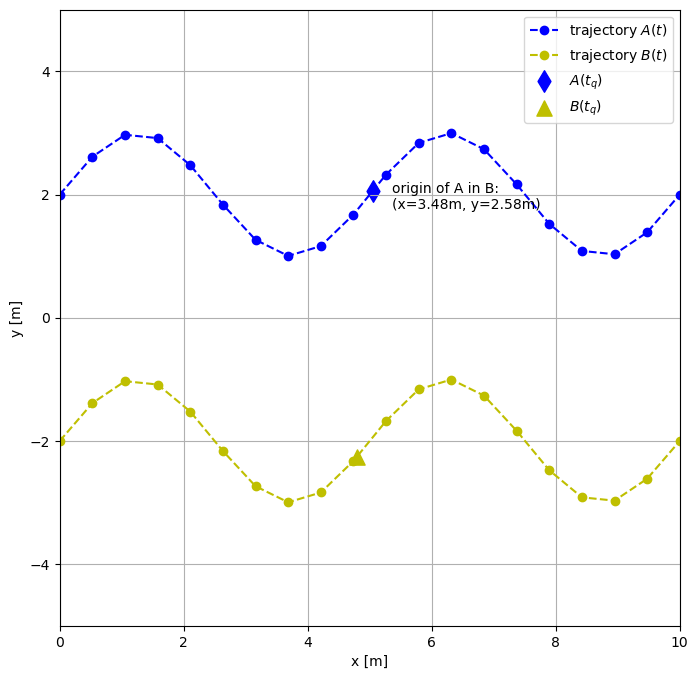

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import (TemporalTransformManager,
                                             NumpyTimeseriesTransform)


def create_sinusoidal_movement(
        duration_sec, sample_period, x_velocity, y_start_offset, start_time):
    """Create a planar (z=0) sinusoidal movement around x-axis."""
    time = np.arange(0, duration_sec, sample_period) + start_time
    n_steps = len(time)
    x = np.linspace(0, x_velocity * duration_sec, n_steps)

    spatial_freq = 1.0 / 5.0  # 1 sinus per 5m
    omega = 2.0 * np.pi * spatial_freq
    y = np.sin(omega * x)
    y += y_start_offset

    dydx = omega * np.cos(omega * x)
    yaw = np.arctan2(dydx, np.ones_like(dydx))

    pqs = []
    for i in range(n_steps):
        R = pr.active_matrix_from_extrinsic_euler_zyx([yaw[i], 0, 0])
        T = pt.transform_from(R, [x[i], y[i], 0])
        pq = pt.pq_from_transform(T)
        pqs.append(pq)

    return time, np.array(pqs)


# create entities A and B together with their transformations from world
duration = 10.0  # [s]
sample_period = 0.5  # [s]
velocity_x = 1  # [m/s]
time_A, pqs_A = create_sinusoidal_movement(
    duration, sample_period, velocity_x, y_start_offset=2.0, start_time=0.1
)
time_B, pqs_B = create_sinusoidal_movement(
    duration, sample_period, velocity_x, y_start_offset=-2.0, start_time=0.35
)

# package them into an instance of `TimeVaryingTransform` abstract class
transform_WA = NumpyTimeseriesTransform(time_A, pqs_A)
transform_WB = NumpyTimeseriesTransform(time_B, pqs_B)

tm = TemporalTransformManager()

tm.add_transform("A", "world", transform_WA)
tm.add_transform("B", "world", transform_WB)

query_time = 4.9  # [s]
A2B_at_query_time = tm.get_transform_at_time("A", "B", query_time)

# transform the origin of A in A (x=0, y=0, z=0) to B
origin_of_A_pos = pt.vector_to_point([0, 0, 0])
origin_of_A_in_B_xyz = pt.transform(A2B_at_query_time, origin_of_A_pos)[:-1]

# for visualization purposes
pq_A = pt.pq_from_transform(transform_WA.as_matrix(query_time))
pq_B = pt.pq_from_transform(transform_WB.as_matrix(query_time))

plt.figure(figsize=(8, 8))
plt.plot(pqs_A[:, 0], pqs_A[:, 1], "bo--", label="trajectory $A(t)$")
plt.plot(pqs_B[:, 0], pqs_B[:, 1], "yo--", label="trajectory $B(t)$")
plt.scatter(pq_A[0], pq_A[1], color="b", s=120, marker="d",
            label="$A(t_q)$")
plt.scatter(pq_B[0], pq_B[1], color="y", s=120, marker="^",
            label="$B(t_q)$")
plt.text(
    pq_A[0] + 0.3,
    pq_A[1] - 0.3,
    f"origin of A in B:\n(x={origin_of_A_in_B_xyz[0]:.2f}m,"
    + f" y={origin_of_A_in_B_xyz[1]:.2f}m)",
)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim(0, 10)
plt.ylim(-5, 5)
plt.grid()
plt.legend()
plt.show()

### [Concatenate Uncertain Transforms](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_concatenate_uncertain_transforms.html#sphx-glr-auto-examples-plots-plot-concatenate-uncertain-transforms-py)
每个姿势都有一个相关的协方差需要考虑。在这个例子中, 我们假设一个机器人以恒定的速度沿 x 轴移动, 然而, 机器人的方向存在噪声, 这些噪声会累积, 导致采样时出现不同的路径。不确定性的积累导致了所谓的香蕉分布, 它在笛卡尔空间中看起来不是高斯分布, 但在 SO(3) 的指数坐标空间中却是高斯分布。

This example adapted and modified to 3D from Barfoot, Furgale: [Associating Uncertainty With Three-Dimensional Poses for Use in Estimation Problems](http://ncfrn.mcgill.ca/members/pubs/barfoot_tro14.pdf) 

The banana distribution was analyzed in detail by Long, Wolfe, Mashner, Chirikjian: [The Banana Distribution is Gaussian: A Localization Study with Exponential Coordinates](http://www.roboticsproceedings.org/rss08/p34.pdf)

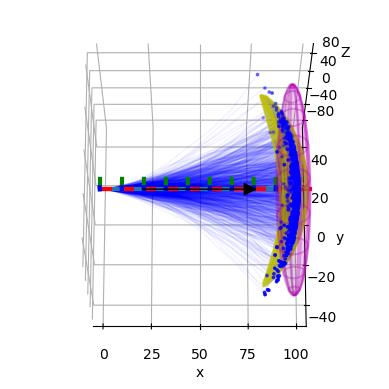

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.uncertainty as pu
import pytransform3d.plot_utils as ppu


rng = np.random.default_rng(0)
cov_pose_chol = np.diag([0, 0.02, 0.03, 0, 0, 0])
cov_pose = np.dot(cov_pose_chol, cov_pose_chol.T)
velocity_vector = np.array([0, 0, 0, 1.0, 0, 0])
T_vel = pt.transform_from_exponential_coordinates(velocity_vector)
n_steps = 100
n_mc_samples = 1000
n_skip_trajectories = 1  # plot every n-th trajectory

T_est = np.eye(4)
path = np.zeros((n_steps + 1, 6))
path[0] = pt.exponential_coordinates_from_transform(T_est)
cov_est = np.zeros((6, 6))
for t in range(n_steps):
    T_est, cov_est = pu.concat_globally_uncertain_transforms(
        T_est, cov_est, T_vel, cov_pose)
    path[t + 1] = pt.exponential_coordinates_from_transform(T_est)

T = np.eye(4)
mc_path = np.zeros((n_steps + 1, n_mc_samples, 4, 4))
mc_path[0, :] = T
for t in range(n_steps):
    noise_samples = ptr.transforms_from_exponential_coordinates(
        cov_pose_chol.dot(rng.standard_normal(size=(6, n_mc_samples))).T)
    step_samples = ptr.concat_many_to_one(noise_samples, T_vel)
    mc_path[t + 1] = np.einsum("nij,njk->nik", step_samples, mc_path[t])
# Plot the random samples' trajectory lines (in a frame attached to the start)
# same as mc_path[t, i, :3, :3].T.dot(mc_path[t, i, :3, 3]), but faster
mc_path_vec = np.einsum(
    "tinm,tin->tim", mc_path[:, :, :3, :3], mc_path[:, :, :3, 3])

ax = ppu.make_3d_axis(100)

for i in range(0, mc_path_vec.shape[1], n_skip_trajectories):
    ax.plot(
        mc_path_vec[:, i, 0], mc_path_vec[:, i, 1], mc_path_vec[:, i, 2],
        lw=1, c="b", alpha=0.05)
ax.scatter(
    mc_path_vec[-1, :, 0], mc_path_vec[-1, :, 1], mc_path_vec[-1, :, 2],
    s=3, c="b")

ptr.plot_trajectory(ax, ptr.pqs_from_transforms(
    ptr.transforms_from_exponential_coordinates(path)), s=5.0, lw=3)

pu.plot_projected_ellipsoid(
    ax, T_est, cov_est, wireframe=False, alpha=0.3, color="y", factor=3.0)
pu.plot_projected_ellipsoid(
    ax, T_est, cov_est, wireframe=True, alpha=0.5, color="y", factor=3.0)

mean_mc = np.mean(mc_path_vec[-1, :], axis=0)
cov_mc = np.cov(mc_path_vec[-1, :], rowvar=False)

ellipsoid2origin, radii = pu.to_ellipsoid(mean_mc, cov_mc)
ppu.plot_ellipsoid(
    ax, 3.0 * radii, ellipsoid2origin, wireframe=False, alpha=0.1, color="m")
ppu.plot_ellipsoid(
    ax, 3.0 * radii, ellipsoid2origin, wireframe=True, alpha=0.3, color="m")

plt.xlim((-5, 105))
plt.ylim((-50, 50))
plt.xlabel("x")
plt.ylabel("y")
ax.view_init(elev=70, azim=-90)
plt.show()

## 机械臂

### [Visualization of 6-DOF robot arm](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_robot.html#sphx-glr-auto-examples-plots-plot-robot-py)

In [ ]:
%cd /mnt/d/github
!git clone https://github.com/dfki-ric/pytransform3d.git

In [37]:
%cd /mnt/d/github/pytransform3d

/mnt/d/github/pytransform3d


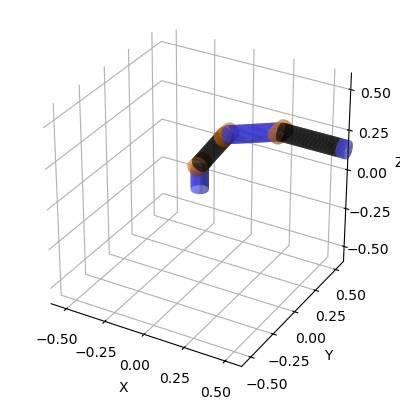

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.urdf import UrdfTransformManager


BASE_DIR = "test/test_data/"
data_dir = BASE_DIR
search_path = "."
while (not os.path.exists(data_dir) and
       os.path.dirname(search_path) != "pytransform3d"):
    search_path = os.path.join(search_path, "..")
    data_dir = os.path.join(search_path, BASE_DIR)

tm = UrdfTransformManager()
filename = os.path.join(data_dir, "robot_with_visuals.urdf")
with open(filename, "r") as f:
    robot_urdf = f.read()
    tm.load_urdf(robot_urdf, mesh_path=data_dir)
tm.set_joint("joint2", 0.2 * np.pi)
tm.set_joint("joint3", 0.2 * np.pi)
tm.set_joint("joint5", 0.1 * np.pi)
tm.set_joint("joint6", 0.5 * np.pi)

tm.plot_visuals("robot_arm", ax_s=0.6, alpha=0.7)
plt.show()

### [URDF Joints](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_urdf.html#sphx-glr-auto-examples-plots-plot-urdf-py)
此示例展示如何加载机器人的 URDF 描述、设置一些关节角度, 并显示相关 frames。

In [39]:
import matplotlib.pyplot as plt
from pytransform3d.urdf import UrdfTransformManager

#### URDF
URDF 必须以字符串形式提供。这些字符串可以从文件中加载。

In [40]:
COMPI_URDF = """
<?xml version="1.0"?>
  <robot name="compi">
    <link name="linkmount"/>
    <link name="link1"/>
    <link name="link2"/>
    <link name="link3"/>
    <link name="link4"/>
    <link name="link5"/>
    <link name="link6"/>
    <link name="tcp"/>

    <joint name="joint1" type="revolute">
      <origin xyz="0 0 0" rpy="0 0 0"/>
      <parent link="linkmount"/>
      <child link="link1"/>
      <axis xyz="0 0 1.0"/>
    </joint>

    <joint name="joint2" type="revolute">
      <origin xyz="0 0 0.158" rpy="1.570796 0 0"/>
      <parent link="link1"/>
      <child link="link2"/>
      <axis xyz="0 0 -1.0"/>
    </joint>

    <joint name="joint3" type="revolute">
      <origin xyz="0 0.28 0" rpy="0 0 0"/>
      <parent link="link2"/>
      <child link="link3"/>
      <axis xyz="0 0 -1.0"/>
    </joint>

    <joint name="joint4" type="revolute">
      <origin xyz="0 0 0" rpy="-1.570796 0 0"/>
      <parent link="link3"/>
      <child link="link4"/>
      <axis xyz="0 0 1.0"/>
    </joint>

    <joint name="joint5" type="revolute">
      <origin xyz="0 0 0.34" rpy="1.570796 0 0"/>
      <parent link="link4"/>
      <child link="link5"/>
      <axis xyz="0 0 -1.0"/>
    </joint>

    <joint name="joint6" type="revolute">
      <origin xyz="0 0.346 0" rpy="-1.570796 0 0"/>
      <parent link="link5"/>
      <child link="link6"/>
      <axis xyz="0 0 1.0"/>
    </joint>

    <joint name="jointtcp" type="fixed">
      <origin xyz="0 0 0.05" rpy="0 0 0"/>
      <parent link="link6"/>
      <child link="tcp"/>
    </joint>
  </robot>
"""

tm = UrdfTransformManager()
tm.load_urdf(COMPI_URDF)

#### Set Joints
在此示例中, 我们手动设置关节角度。关节通过从 URDF 中提取的字符串名称进行识别。

In [41]:
joint_names = ["joint%d" % i for i in range(1, 7)]
joint_angles = [0, 0.5, 0.5, 0, 0.5, 0]
for name, angle in zip(joint_names, joint_angles):
    tm.set_joint(name, angle)

#### Visualization
我们使用 matplotlib 来可视化 URDF 的 link frames 及它们之间的拼接。

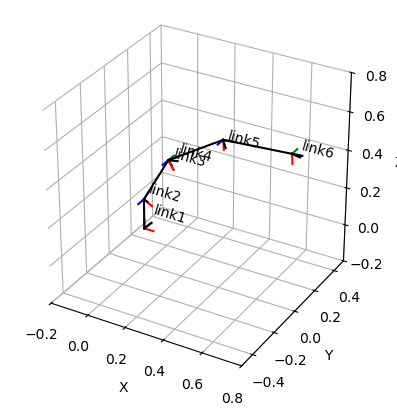

In [42]:
ax = tm.plot_frames_in("compi", whitelist=["link%d" % d for d in range(1, 7)],
                       s=0.05, show_name=True)
ax = tm.plot_connections_in("compi", ax=ax)
ax.set_xlim((-0.2, 0.8))
ax.set_ylim((-0.5, 0.5))
ax.set_zlim((-0.2, 0.8))
plt.show()

### [URDF with Meshes](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_urdf_with_meshes.html#sphx-glr-auto-examples-plots-plot-urdf-with-meshes-py)
此示例展示了如何使用 STL meshes 加载 URDF。


In [ ]:
!pip install trimesh

In [43]:
%cd /mnt/d/github/pytransform3d

/mnt/d/github/pytransform3d


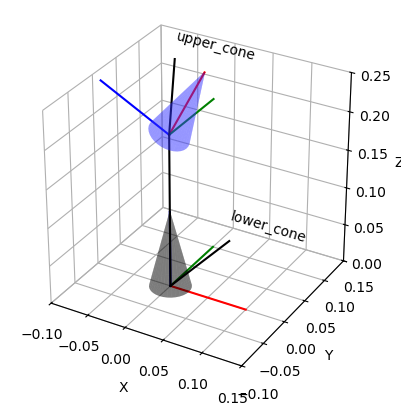

In [46]:
import os
import matplotlib.pyplot as plt
from pytransform3d.urdf import UrdfTransformManager


BASE_DIR = "test/test_data/"
data_dir = BASE_DIR
search_path = "."
while (not os.path.exists(data_dir) and
       os.path.dirname(search_path) != "pytransform3d"):
    search_path = os.path.join(search_path, "..")
    data_dir = os.path.join(search_path, BASE_DIR)

tm = UrdfTransformManager()
with open(os.path.join(data_dir, "simple_mechanism.urdf"), "r") as f:
    tm.load_urdf(f.read(), mesh_path=data_dir)
tm.set_joint("joint", -1.1)
ax = tm.plot_frames_in(
    "lower_cone", s=0.1, whitelist=["upper_cone", "lower_cone"],
    show_name=True)
ax = tm.plot_connections_in("lower_cone", ax=ax)
tm.plot_visuals("lower_cone", ax=ax)
ax.set_xlim((-0.1, 0.15))
ax.set_ylim((-0.1, 0.15))
ax.set_zlim((0.0, 0.25))
plt.show()

### [URDF with Collision Objects](https://dfki-ric.github.io/pytransform3d/_auto_examples/plots/plot_collision_objects.html#sphx-glr-auto-examples-plots-plot-collision-objects-py)
此示例展示如何加载带有碰撞对象的 URDF 描述, 并显示它们。



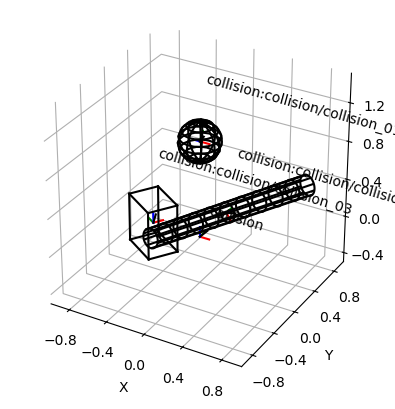

In [47]:
import matplotlib.pyplot as plt
from pytransform3d.urdf import UrdfTransformManager


URDF = """
<?xml version="1.0"?>
  <robot name="collision">
    <link name="collision">
      <collision name="collision_01">
        <origin xyz="0 0 1" rpy="1 0 0"/>
        <geometry>
          <sphere radius="0.2"/>
        </geometry>
      </collision>
      <collision name="collision_02">
        <origin xyz="0 0.5 0" rpy="0 1 0"/>
        <geometry>
          <cylinder radius="0.1" length="2"/>
        </geometry>
      </collision>
      <collision name="collision_03">
        <origin xyz="-0.5 0 0" rpy="0 0 1"/>
        <geometry>
          <box size="0.3 0.4 0.5"/>
        </geometry>
      </collision>
  </robot>
"""


tm = UrdfTransformManager()
tm.load_urdf(URDF)
ax = tm.plot_frames_in("collision", s=0.1)
tm.plot_collision_objects("collision", ax)
ax.set_zlim((-0.5, 1.5))
plt.show()

### agilex URDF 计算 end-effector, 并可视化

todo: https://github.com/IRP-TU-BS/urdf_viz  

In [ ]:
%cd /mnt/d/github
!git clone https://github.com/dfki-ric/pytransform3d.git
!git clone https://github.com/agilexrobotics/mobile_aloha_sim.git

In [52]:
# copy from https://github.com/agilexrobotics/mobile_aloha_sim/blob/master/aloha_isaac_sim/urdf/arx5_description_isaac.urdf
# and then replace `package://aloha_isaac_sim/meshes` by `.`

COMPI_URDF = """
<?xml version="1.0" encoding="utf-8" ?>
<robot name="arx5_description" xmlns:xacro="http://www.ros.org/wiki/xacro">

    <link name="fr_base_link">
        <inertial>
            <origin xyz="-2.9972E-05 3.056E-05 0.027301" rpy="0 0 0" />
            <mass value="0.44038" />
            <inertia ixx="0.00017" ixy="0.00000" ixz="0.00000" iyy="0.00018" iyz="0.00000" izz="0.00016" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./base_arm.STL" />
            </geometry>
            <material name="">
                <color rgba="0.75294 0.75294 0.75294 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./base_arm.STL" />
            </geometry>
        </collision>
    </link>

    <link name="fr_link1">
        <inertial>
            <origin xyz="0.00609525411893452 -0.00429681977500749 0.0179590247477389" rpy="0 0 0" />
            <mass value="0.0608351104988555" />
            <inertia ixx="0.00008" ixy="0.00000" ixz="0.00001" iyy="0.00003" iyz="0.00000" izz="0.00007" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link1.STL" />
            </geometry>
            <material name="">
                <color rgba="0.752941176470588 0.752941176470588 0.752941176470588 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link1.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint1" type="revolute">
        <origin xyz="0 0 0.0603" rpy="0 0 0" />
        <parent link="fr_base_link" />
        <child link="fr_link1" />
        <axis xyz="0 0 1" />
        <limit lower="-10" upper="10" effort="100" velocity="1000" />
    </joint>
    <link name="fr_link2">
        <inertial>
            <origin xyz="-0.132382037190567 0.00220380675553821 0.000111790164679923" rpy="0 0 0" />
            <mass value="1.0733279014126" />
            <inertia ixx="0.00050" ixy="0.00000" ixz="-0.00004" iyy="0.01596" iyz="0.00000" izz="0.01602" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link2.STL" />
            </geometry>
            <material name="">
                <color rgba="0.752941176470588 0.752941176470588 0.752941176470588 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link2.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint2" type="revolute">
        <origin xyz="0.02 0 0.0402" rpy="0 0 0" />
        <parent link="fr_link1" />
        <child link="fr_link2" />
        <axis xyz="0 1 0" />
        <limit lower="-10" upper="10" effort="100" velocity="1000" />
    </joint>
    <link name="fr_link3">
        <inertial>
            <origin xyz="0.187203287369961 -0.000305676361444925 -0.0514832866415513" rpy="0 0 0" />
            <mass value="0.499404738025019" />
            <inertia ixx="0.00033" ixy="-0.00006" ixz="-0.00039" iyy="0.00387" iyz="0.00001" izz="0.00383" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link3.STL" />
            </geometry>
            <material name="">
                <color rgba="0.752941176470588 0.752941176470588 0.752941176470588 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link3.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint3" type="revolute">
        <origin xyz="-0.264 0 0" rpy="-3.1416 0 0" />
        <parent link="fr_link2" />
        <child link="fr_link3" />
        <axis xyz="0 1 0" />
        <limit lower="-10" upper="10" effort="100" velocity="1000" />
    </joint>
    <link name="fr_link4">
        <inertial>
            <origin xyz="0.0388884702662706 0.00295168681334743 -0.0353282735009622" rpy="0 0 0" />
            <mass value="0.0809712553169999" />
            <inertia ixx="0.00013" ixy="-0.00001" ixz="-0.00006" iyy="0.00016" iyz="0.00001" izz="0.00010" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link4.STL" />
            </geometry>
            <material name="">
                <color rgba="0.898039215686275 0.917647058823529 0.929411764705882 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link4.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint4" type="revolute">
        <origin xyz="0.245 0 -0.056" rpy="0 0 0" />
        <parent link="fr_link3" />
        <child link="fr_link4" />
        <axis xyz="0 1 0" />
        <limit lower="-10" upper="10" effort="100" velocity="1000" />
    </joint>
    <link name="fr_link5">
        <inertial>
            <origin xyz="0.00289956909960302 3.15826689885766E-05 0.0526188859211408" rpy="0 0 0" />
            <mass value="0.602357399313257" />
            <inertia ixx="0.00072" ixy="0.00000" ixz="0.00005" iyy="0.00069" iyz="0.00000" izz="0.00021" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link5.STL" />
            </geometry>
            <material name="">
                <color rgba="0.752941176470588 0.752941176470588 0.752941176470588 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link5.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint5" type="revolute">
        <origin xyz="0.06575 -0.001 -0.0825" rpy="0 0 0" />
        <parent link="fr_link4" />
        <child link="fr_link5" />
        <axis xyz="0 0 1" />
        <limit lower="-10" upper="10" effort="100" velocity="1000" />
    </joint>
    <link name="fr_link6">
        <inertial>
            <origin xyz="0.0471798400661976 0.000102970421835668 -0.000138510949393961" rpy="0 0 0" />
            <mass value="0.462244960775882" />
            <inertia ixx="0.00068" ixy="0.00000" ixz="0.00000" iyy="0.00036" iyz="-0.00001" izz="0.00091" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link6.STL" />
            </geometry>
            <material name="">
                <color rgba="0.898039215686275 0.917647058823529 0.929411764705882 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link6.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint6" type="revolute">
        <origin xyz="0.02845 0 0.0825" rpy="-3.1416 0 0" />
        <parent link="fr_link5" />
        <child link="fr_link6" />
        <axis xyz="1 0 0" />
        <limit lower="-10" upper="10" effort="100" velocity="1000" />
    </joint>
    <link name="fr_link7">
        <inertial>
            <origin xyz="-0.000327642774520215 -0.00482005374028087 -0.00167540868720402" rpy="0 0 0" />
            <mass value="0.0484016660227936" />
            <inertia ixx="0.00001" ixy="0.00000" ixz="0.00000" iyy="0.00002" iyz="0.00000" izz="0.00002" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link7.STL" />
            </geometry>
            <material name="">
                <color rgba="0.898039215686275 0.917647058823529 0.929411764705882 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link7.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint7" type="prismatic">
        <origin xyz="0.073574 0.024629 0" rpy="0 0 0" />
        <parent link="fr_link6" />
        <child link="fr_link7" />
        <axis xyz="0 1 0" />
        <limit lower="0" upper="0.04765" effort="100" velocity="100" />
    </joint>
    <link name="fr_link8">
        <inertial>
            <origin xyz="-0.000327643744208572 0.00482005363510456 0.000752972893839382" rpy="0 0 0" />
            <mass value="0.0484016646136083" />
            <inertia ixx="0.00001" ixy="0.00000" ixz="0.00000" iyy="0.00002" iyz="0.00000" izz="0.00002" />
        </inertial>
        <visual>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link8.STL" />
            </geometry>
            <material name="">
                <color rgba="0.898039215686275 0.917647058823529 0.929411764705882 1" />
            </material>
        </visual>
        <collision>
            <origin xyz="0 0 0" rpy="0 0 0" />
            <geometry>
                <mesh filename="./link8.STL" />
            </geometry>
        </collision>
    </link>
    <joint name="fr_joint8" type="prismatic">
        <origin xyz="0.073574 -0.024629 0" rpy="0 0 0" />
        <parent link="fr_link6" />
        <child link="fr_link8" />
        <axis xyz="0 -1 0" />
        <limit lower="0" upper="0.04765" effort="100" velocity="100" />
    </joint>
    
</robot>
"""

#### read urdf, set joints, and set whitelist of link

In [53]:
import os
import numpy as np
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d import rotations
from pytransform3d import transformations
import matplotlib.pyplot as plt

PATHROOT = "/mnt/d/github/mobile_aloha_sim/aloha_isaac_sim"
# PATHURDF = os.path.join(PATHROOT, "urdf/arx5_description_isaac.urdf")
PATHMESH = os.path.join(PATHROOT, "meshes")

# read urdf
tm = UrdfTransformManager()

tm.load_urdf(COMPI_URDF, mesh_path=PATHMESH)
# with open(PATHURDF, "r") as f:
#     tm.load_urdf(f.read(), mesh_path=PATHMESH)
    
# set joints
for idx, radian in enumerate([0.0, 1.8, 1.2, -0.6, -0.2, 0.0, 0.0]):
    tm.set_joint("fr_joint" + str(idx+1), radian)

# link 白名单
whitelist = ["fr_link%d" % d for d in range(1, 9)] + ["fr_base_link"] 

#### invert transform transform concatenation and invert transform

In [54]:
# Transform from fr_base_link to fr_link0
link_base_to_0 = tm.get_transform(whitelist[-1], whitelist[0])
# Transform from fr_link0 to fr_link1
link_0_to_1 = tm.get_transform(whitelist[0], whitelist[1])
# Transform from fr_link1 to fr_link2
link_1_to_2 = tm.get_transform(whitelist[1], whitelist[2])
# Transform from fr_link2 to fr_link3
link_2_to_3 = tm.get_transform(whitelist[2], whitelist[3])
# Transform from fr_link3 to fr_link4
link_3_to_4 = tm.get_transform(whitelist[3], whitelist[4])
# Transform from fr_link4 to fr_link5
link_4_to_5 = tm.get_transform(whitelist[4], whitelist[5])
# Transform from fr_link5 to fr_link6
link_5_to_6 = tm.get_transform(whitelist[5], whitelist[6])

# Transform from fr_base_link to fr_link6
link_base_to_6 = tm.get_transform(whitelist[-1], whitelist[6])

In [57]:
# Transform 矩阵左乘拼接
link_base_to_6 - link_5_to_6 @ link_4_to_5 @ link_3_to_4 @ link_2_to_3 @ link_1_to_2 @ link_0_to_1 @ link_base_to_0 < 1e-15

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [60]:
# Transform Concatenation
np.array_equal(tm.get_transform(whitelist[1], whitelist[3]), transformations.concat(link_1_to_2, link_2_to_3))

True

In [75]:
# Transform from fr_link6 to fr_base_link
link_6_to_base = tm.get_transform("fr_link6", "fr_base_link")

In [76]:
link_base_to_6, link_6_to_base

(array([[ 3.55133303e-01,  1.98673396e-01, -9.13460026e-01,
         -3.56035030e-02],
        [-7.20032314e-02,  9.80065754e-01,  1.85166555e-01,
         -3.91106099e-02],
        [ 9.32038557e-01,  1.32632190e-05,  3.62359115e-01,
         -3.88679656e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 3.55133303e-01, -7.20032314e-02,  9.32038557e-01,
          3.47737115e-01],
        [ 1.98673396e-01,  9.80065754e-01,  1.32632190e-05,
          6.65435748e-03],
        [-9.13460026e-01,  1.85166555e-01,  3.62359115e-01,
          1.78207657e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]))

In [96]:
link_base_to_6[:3, :3] @ np.transpose(link_base_to_6[:3, :3]) - np.eye(3) < 1e-15

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [97]:
link_6_to_base[:3, :3] @ np.transpose(link_6_to_base[:3, :3]) - np.eye(3) < 1e-15

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [105]:
# invert transform
# base to 6 的 逆
R = np.eye(4)
R[:3, :3] = np.transpose(link_base_to_6[:3, :3])
R[:3, -1] = - np.transpose(link_base_to_6[:3, :3]) @ link_base_to_6[:3, -1]
R - transformations.invert_transform(link_base_to_6) < 1e-15

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

$$
T = \begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}, \quad
T^{-1} = \begin{bmatrix}
R^{T} & -R^{T} \cdot t \\
0 & 1
\end{bmatrix}
$$

In [119]:
# todo: fr_base_link to fr_link6 的变换矩阵的逆 不等于 fr_link6 to fr_base_link 的变换!!!
transformations.invert_transform(tm.get_transform("fr_base_link", "fr_link6")) - tm.get_transform("fr_link6", "fr_base_link")

array([[-5.55111512e-17,  1.38777878e-17, -1.11022302e-16,
         5.55111512e-17],
       [ 0.00000000e+00,  1.11022302e-16, -7.15065214e-18,
         1.73472348e-18],
       [-1.11022302e-16,  5.55111512e-17,  2.22044605e-16,
         2.77555756e-17],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [118]:
transformations.invert_transform(link_base_to_6) @ point_in_link_6, R @ point_in_link_6, point_in_link_base

(array([ 0.42394179,  0.07441591, -0.01780395,  1.        ]),
 array([ 0.42394179,  0.07441591, -0.01780395,  1.        ]),
 array([0.39958658, 0.03566067, 0.04484249, 1.        ]))

#### calculate x, y, z

In [114]:
# gripper in fr_link6 坐标系
point_in_link_6 =  transformations.vector_to_point(np.array([0.146, 0, 0])) # (x, y, z)  -> (x, y, z, 1)
# gripper in fr_base_link 坐标系
point_in_link_base = transformations.transform(link_6_to_base, point_in_link_6, strict_check=True)
point_in_link_6, point_in_link_base

(array([0.146, 0.   , 0.   , 1.   ]),
 array([0.39958658, 0.03566067, 0.04484249, 1.        ]))

In [80]:
np.array_equal(point_in_link_base, np.matmul(link_6_to_base, point_in_link_6))

True

In [81]:
np.array_equal(point_in_link_base, link_6_to_base @ point_in_link_6)

True

#### calculate roll, pitch, yaw (todo)

In [ ]:
rpy = rotations.extrinsic_euler_xyz_from_active_matrix(link_6_to_base[0:3, 0:3]) # todo
rpy2 = rotations.intrinsic_euler_xyz_from_active_matrix(link_6_to_base[0:3, 0:3])

#### visualization

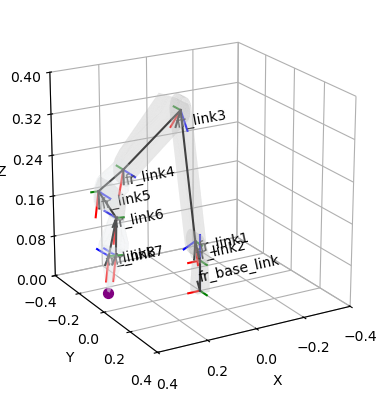

In [92]:
# 绘制 link 的坐标系
ax = tm.plot_frames_in("fr_base_link", whitelist=whitelist, s=0.05, show_name=True)
# 绘制 link 之间的 joint
ax = tm.plot_connections_in("fr_base_link", whitelist=whitelist, ax=ax)
# 绘制模型
ax = tm.plot_visuals("fr_base_link", ax=ax, alpha=0.2)
# 在 fr_base_link 坐标系中, 绘制 gripper point
ax.scatter(point_in_link_base[0], point_in_link_base[1], point_in_link_base[2], s=50, c="purple")

ax.set_xlim((-0.4, 0.4))
ax.set_ylim((-0.4, 0.4))
ax.set_zlim((0.0, 0.4))
ax.view_init(azim=60, elev=20)

# [Robotics Toolbox for Python](https://github.com/petercorke/robotics-toolbox-python)
https://blog.csdn.net/xiaoding_ding/article/details/111314717  
https://blog.51cto.com/goody/6616207  

In [5]:
import numpy as np
from roboticstoolbox import DHRobot, RevoluteDH
from roboticstoolbox.tools import URDF

In [12]:
%cd /home/qj00182/robot/isaac/aloha_isaac_sim/urdf

/home/qj00182/robot/isaac/aloha_isaac_sim/urdf


In [ ]:
# 定义 URDF 文件路径
urdf_file = "/home/qj00182/robot/isaac/aloha_isaac_sim/urdf/arx5_description_isaac_nodae_edit.urdf"  # 替换为你的 URDF 文件路径

# 加载 URDF 模型
robot = URDF.load(urdf_file)

In [ ]:
# 设置关节角度（以弧度为单位）
joint_angles = [np.pi / 4, np.pi / 4, np.pi / 6, -np.pi / 3, np.pi / 2, -np.pi / 4]  # 示例角度

# 计算正运动学
end_effector_transform = robot.fkine(joint_angles)

# 提取位置和姿态
position = end_effector_transform.t
rpy = end_effector_transform.rpy()  # 计算滚转、俯仰、偏航角

print(f"末端位置: {position}")
print(f"姿态 (RPY): {rpy}")

# todo
- [PyTorch Robot Kinematics](https://github.com/UM-ARM-Lab/pytorch_kinematics)
- [N joint arm to point control](https://github.com/AtsushiSakai/PythonRobotics/tree/master?tab=readme-ov-file#n-joint-arm-to-point-control)
- [Arm navigation with obstacle avoidance](https://github.com/AtsushiSakai/PythonRobotics/tree/master?tab=readme-ov-file#arm-navigation-with-obstacle-avoidance)
- https://www.shenlanxueyuan.com/course/727?source=1